In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
import re

regex = re.compile(r'^[\d]+_x=([-\d.]+)_z=([-\d.]+)_a=([-\d.]+)_h=([-\d.]+)[.]csv$')

def label_from_path(path):
    label = path.split('\\')[-1] # PLATFORM DEPENDENT!
    m = regex.match(label)
    out = [float(x) for x in m.groups()]
    return torch.tensor(out, dtype=torch.float)

In [3]:
def data_from_path(path):
    data = pd.read_csv(path, sep=';')

    time = data.values[:,0]
    vx   = data.values[:,1::2]
    vz   = data.values[:,2::2]
    vabs = (vx ** 2 + vz ** 2) ** (1/2)
    
    vx   = torch.from_numpy(vx)
    vz   = torch.from_numpy(vz)
    vabs = torch.from_numpy(vabs)
    
    vx_fft   = torch.view_as_real(torch.fft.fft(vx)).permute(2, 0, 1)
    vz_fft   = torch.view_as_real(torch.fft.fft(vz)).permute(2, 0, 1)
    vabs_fft = torch.view_as_real(torch.fft.fft(vabs)).permute(2, 0, 1)

    ret = torch.cat([vx.unsqueeze(0), vz.unsqueeze(0), vabs.unsqueeze(0), vx_fft, vz_fft, vabs_fft], dim=0)

    return ret

In [4]:
class CSVDataset(Dataset):
    def __init__(self, path, device):
        self.device = device
        self.csv_list = [
            (path + "\\" + i) for i in os.listdir(path) if i.split('.')[-1] == 'csv'
        ]

    def __getitem__(self, item):
        d = data_from_path(self.csv_list[item]).to(device=device, dtype=torch.float)
        l = label_from_path(self.csv_list[item]).to(device=device, dtype=torch.float)
        return d, l

    def __len__(self):
        return len(self.csv_list)

In [5]:
class Predictor(nn.Module):
    def __init__(self):
        super(Predictor, self).__init__()

        self.feature_extractor = nn.Sequential(
            #        in  out  ker size
            nn.Conv2d(9, 32, 3),     # 9 = len([v_x, v_y, v_abs, 2*fft_vx, 2*fft_vy, 2*fft_vabs, ])
            nn.MaxPool2d(2, 2), 
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 512, 3, 2),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),

            nn.Conv2d(512, 1024, 3, 2),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),

            nn.Conv2d(1024, 512, 2),
        )

        self.linear = nn.Linear(45, 256)
        self.conv = nn.Sequential(
            nn.Conv2d(512, 1, 1),
            nn.ReLU(inplace=True)
            )

        self.linear2 = nn.Linear(256, 4) # 4 = x, z, a, h

    def forward(self, input):
        x = self.feature_extractor(input)
        x = x.permute(0, 1, 3, 2)
        x = self.linear(x)
        x = self.conv(x)
        x = x.squeeze(1).squeeze(1)
        x = self.linear2(x)

        return x

In [6]:
predictor = Predictor().to(device)
data_loader = DataLoader(CSVDataset(".\\csv", device), batch_size=8, shuffle=True)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(predictor.parameters(), lr=0.0003)

In [7]:
from tqdm import tqdm

num_epochs = 25
all_loss = []

for epoch in range(num_epochs):
    progress = tqdm(data_loader)
    running_loss = []
    for inputs, label in progress:
        # zero the parameter gradients
        optimizer.zero_grad()
        # predict
        outputs = predictor(inputs)
        # loss
        loss = loss_fn(outputs, label)
        running_loss.append(loss.item())
        loss.backward()
        optimizer.step()

        # print statistics
        progress.set_description(f"loss: {loss.item()}")
    
    all_loss.append(running_loss)
    torch.save(predictor.state_dict(), f'.\\weights\\lastest_{epoch}_{np.mean(running_loss)}')

print('Finished Training')

loss: 673.7460327148438: 100%|███████████████████████████████████████████████████████| 750/750 [08:56<00:00,  1.40it/s]

Finished Training


In [9]:
from tqdm import tqdm

predictor = Predictor().to(device)
loss_fn = nn.MSELoss()

weight_path = ".\\w4"
epoch_list = [ (weight_path + "\\" + i) for i in os.listdir(weight_path)]

out_list = []

print(epoch_list)

['.\\w4\\lastest_0_46180.8893523763', '.\\w4\\lastest_10_969.7212858479818', '.\\w4\\lastest_11_896.4830109863282', '.\\w4\\lastest_12_907.1207577718098', '.\\w4\\lastest_13_753.7879975585937', '.\\w4\\lastest_14_733.2922454833985', '.\\w4\\lastest_15_725.1300467325847', '.\\w4\\lastest_16_622.0657198079427', '.\\w4\\lastest_17_649.0316087646485', '.\\w4\\lastest_18_608.774219136556', '.\\w4\\lastest_19_561.3580904947917', '.\\w4\\lastest_1_4253.4193082682295', '.\\w4\\lastest_20_538.3093043416341', '.\\w4\\lastest_21_544.007084991455', '.\\w4\\lastest_22_504.05983953857424', '.\\w4\\lastest_23_560.1508313090006', '.\\w4\\lastest_24_419.16999172973635', '.\\w4\\lastest_2_2794.8280506184897', '.\\w4\\lastest_3_2159.5597272949217', '.\\w4\\lastest_4_1845.9795686035156', '.\\w4\\lastest_5_1666.5838186035157', '.\\w4\\lastest_6_1590.0135607503255', '.\\w4\\lastest_7_1248.1552843017578', '.\\w4\\lastest_8_1296.2617186279297', '.\\w4\\lastest_9_1049.217219543457']


In [10]:
for fname in epoch_list:
    predictor.load_state_dict(torch.load(fname))
    test_data_loader = DataLoader(CSVDataset(".\\csv_test", device), batch_size=8, shuffle=True)
    total_loss = 0
    for data, label in tqdm(test_data_loader):
        with torch.no_grad():
            outputs = predictor(data)
            total_loss += loss_fn(outputs, label)
    
    out_list.append( (fname, total_loss / len(test_data_loader)) )

100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:46<00:00,  1.62it/s]


Train loss        Test loss
46180.8893523763 5429.99072265625
969.7212858479818 1187.9425048828125
896.4830109863282 1065.7484130859375
907.1207577718098 983.3062744140625
753.7879975585937 856.3779907226562
733.2922454833985 759.1427001953125
725.1300467325847 851.9904174804688
622.0657198079427 868.0095825195312
649.0316087646485 781.4510498046875
608.774219136556 658.8756713867188
561.3580904947917 881.4955444335938
4253.4193082682295 4933.7705078125
538.3093043416341 760.9243774414062
544.007084991455 711.6118774414062
504.05983953857424 563.680908203125
560.1508313090006 648.5636596679688
419.16999172973635 623.5989990234375
2794.8280506184897 2491.6787109375
2159.5597272949217 1930.45068359375
1845.9795686035156 1720.1646728515625
1666.5838186035157 1796.9058837890625
1590.0135607503255 1338.5537109375
1248.1552843017578 1862.1248779296875
1296.2617186279297 2187.4775390625
1049.217219543457 1324.35546875


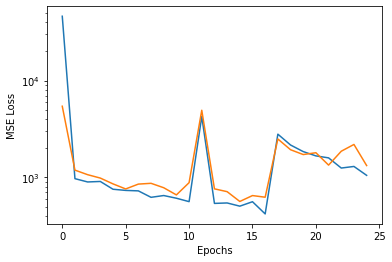

In [11]:
import matplotlib.pyplot as plt

a = []
b = []

print("Train loss        Test loss")
for x in out_list:
    a.append(float(x[0].split('_')[-1]))
    b.append(float(x[1]))
    print(a[-1], b[-1])
    
plt.yscale("log")

plt.xlabel('Epochs')
plt.ylabel('MSE Loss')

plt.plot(a)
plt.plot(b)
plt.show()

In [15]:
# BEST EPOCH IS 14
print("Train loss        Test loss")
print(a[16], b[16])

Train loss        Test loss
419.16999172973635 623.5989990234375
